In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

# Remember, the windows are the INVERSE of the absorption features
# Next - build ability to choose seed (both in make_specs and empca)

Populating the interactive namespace from numpy and matplotlib


[ 0.54506222  0.6008077   0.60125637  0.60173421  0.60245918  0.60306632] [ 0.54506222  0.60133191  0.60229038  0.60317046  0.6041082   0.60494799]
var, Vnoise  6.74510321576e-05 6.07896767045e-05
[ 0.54506222  0.82910439  0.86719337  0.88299342  0.91406589  0.93710289] [ 0.54506222  0.63606315  0.85401734  0.8891758   0.96781257  0.97563457]
var, Vnoise  1.0403929493e-05 4.16571962045e-05


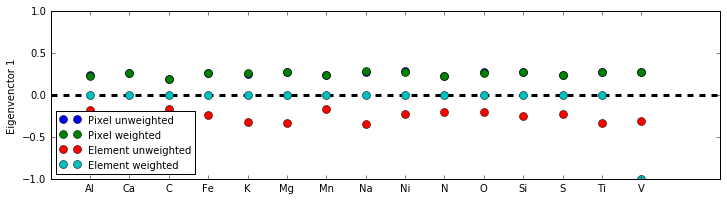

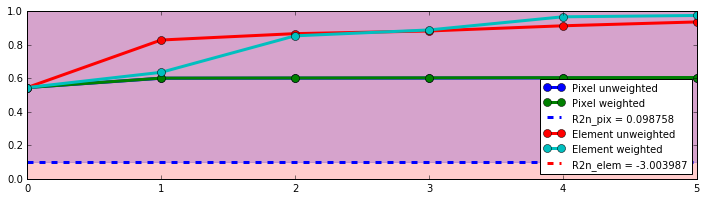

In [24]:
run test_empca -i 1

In [13]:
np.median(specs,axis=1).shape

(846,)

In [20]:
 m1,m2,w1,w2 = pix_empca(None,falsespecs.T,noise,'test.pkl',nvecs=5,deltR2=2e-3,gen=True,usemad=False,randseed=1)

In [21]:
m1

In [23]:
m2.R2(0)

0.0